In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import torch

import cv2
import numpy as np
import matplotlib.pyplot as plt

import yaml

import sys
path_to_repo = "/home/d-shlenskii/repositories/resshift-continuous-in-time"
sys.path.append(path_to_repo)

from utils import instantiate_from_config, prepare_model
from samplers import EulerSampler, HeunSampler

In [76]:
def plot_tensor(out):
    out = (out[0].permute(1, 2, 0).detach().cpu().numpy() + 1.) * 0.5
    plt.imshow(out)
    plt.show()

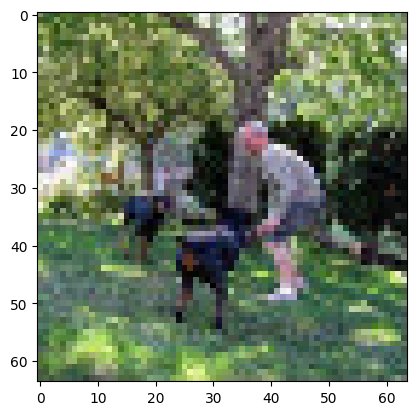

In [77]:
im = cv2.imread(f"{path_to_repo}/testdata/Val_SR/lq/ILSVRC2012_val_00000134.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [78]:
%reload_ext autoreload

In [79]:
with open("pgd.yaml") as file:
    config = yaml.safe_load(file)

ae_config = config["autoencoder"]
ae_config["ckpt_path"] = f"{path_to_repo}/{ae_config['ckpt_path']}"
ae = instantiate_from_config(ae_config)
ae = prepare_model(ae, ae_config)

model_config = config["model"]
model_config["ckpt_path"] = f"{path_to_repo}/{model_config['ckpt_path']}"
model = instantiate_from_config(model_config)
model = prepare_model(model, model_config)
model.cuda()

device = "cuda" if torch.cuda.is_available() else "cpu"

euler_sampler = EulerSampler(ae=ae, x0_pred_fn=model, device=device)
heun_sampler = HeunSampler(ae=ae, x0_pred_fn=model, device=device)

In [80]:
nfe = 15
lq = ((torch.tensor(im).permute(2, 0, 1)[None] / 255.) - 0.5) / 0.5

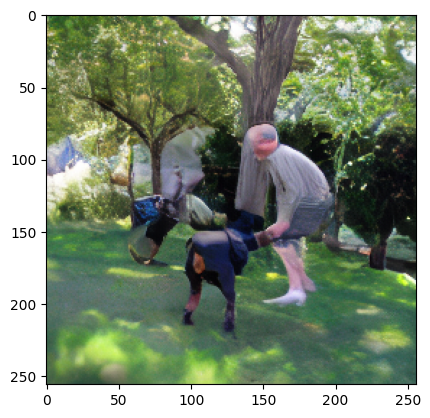

In [81]:
timesteps = torch.tensor(list(np.linspace(0, 1, nfe + 1))[::-1])
out = euler_sampler(timesteps, lq)
plot_tensor(out)

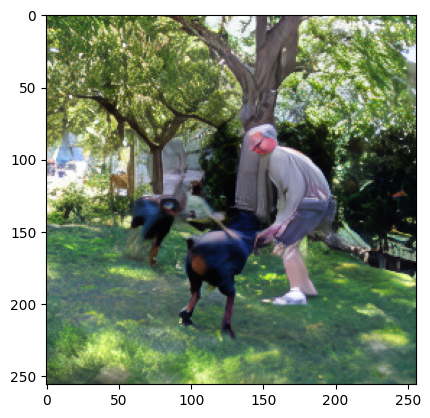

In [82]:
timesteps = torch.tensor(list(np.linspace(0, 1, nfe//2 + 1))[::-1])
out = heun_sampler(timesteps, lq)
plot_tensor(out)